# **Porftolio Drones**

### Inladen van de libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import cv2
import PIL
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

### Inladen en splitsen van de data

In [2]:
def laad_afbeeldingen(map_pad):
    afbeeldingen = []
    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            breedte, hoogte = afbeelding.size
            helft_breedte = breedte // 2
            helft_hoogte = hoogte // 2
            
            kwadrant_1 = np.array(afbeelding.crop((0, 0, helft_breedte, helft_hoogte)))
            kwadrant_2 = np.array(afbeelding.crop((helft_breedte, 0, breedte, helft_hoogte)))
            kwadrant_3 = np.array(afbeelding.crop((0, helft_hoogte, helft_breedte, hoogte)))
            kwadrant_4 = np.array(afbeelding.crop((helft_breedte, helft_hoogte, breedte, hoogte)))
            
            afbeeldingen.extend([kwadrant_1, kwadrant_2, kwadrant_3, kwadrant_4])

    return np.array(afbeeldingen, dtype=object)

def splits_en_opslaan_afbeeldingen(map_pad, nieuwe_map_pad):
    if not os.path.exists(nieuwe_map_pad):
        os.makedirs(nieuwe_map_pad)

    bestandsnamen = os.listdir(map_pad)

    for bestandsnaam in bestandsnamen:
        afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        if os.path.isfile(afbeelding_pad):
            afbeelding = Image.open(afbeelding_pad)
            breedte, hoogte = afbeelding.size
            helft_breedte = breedte // 2
            helft_hoogte = hoogte // 2

            kwadrant_1 = afbeelding.crop((0, 0, helft_breedte, helft_hoogte))
            kwadrant_2 = afbeelding.crop((helft_breedte, 0, breedte, helft_hoogte))
            kwadrant_3 = afbeelding.crop((0, helft_hoogte, helft_breedte, hoogte))
            kwadrant_4 = afbeelding.crop((helft_breedte, helft_hoogte, breedte, hoogte))

            # Opslaan van de de delen van de afbeelding
            kwadrant_1.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel1.jpg'))
            kwadrant_2.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel2.jpg'))
            kwadrant_3.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel3.jpg'))
            kwadrant_4.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel4.jpg'))

image_map_pad = 'images'
nieuwe_image_map_pad = 'image_kwadranten'
splits_en_opslaan_afbeeldingen(image_map_pad, nieuwe_image_map_pad)

mask_map_pad = 'masks'
nieuwe_mask_map_pad = 'mask_kwadranten'
splits_en_opslaan_afbeeldingen(mask_map_pad, nieuwe_mask_map_pad)

(4208,)

(4208,)

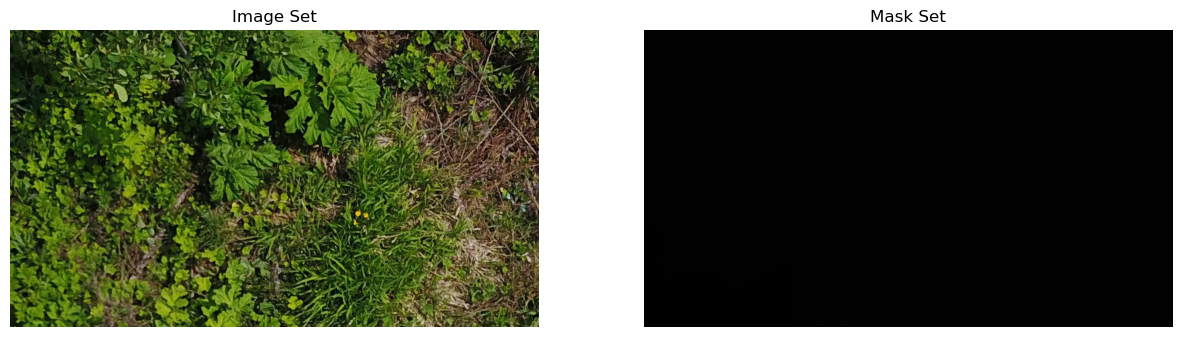

In [3]:
def toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen):
    train_afbeelding = train_afbeeldingen[np.random.randint(len(train_afbeeldingen))]
    test_afbeelding = test_afbeeldingen[np.random.randint(len(test_afbeeldingen))]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(train_afbeelding)
    axs[0].set_title("Image Set")
    axs[0].axis('off')
    axs[1].imshow(test_afbeelding)
    axs[1].set_title("Mask Set")
    axs[1].axis('off')
    plt.show()

image_map_pad = 'image_kwadranten'
image_afbeeldingen = laad_afbeeldingen(image_map_pad)

mask_map_pad = 'mask_kwadranten'
mask_afbeeldingen = laad_afbeeldingen(mask_map_pad)

display(image_afbeeldingen.shape, mask_afbeeldingen.shape)
toon_willekeurige_afbeeldingen_per_set(image_afbeeldingen, mask_afbeeldingen)

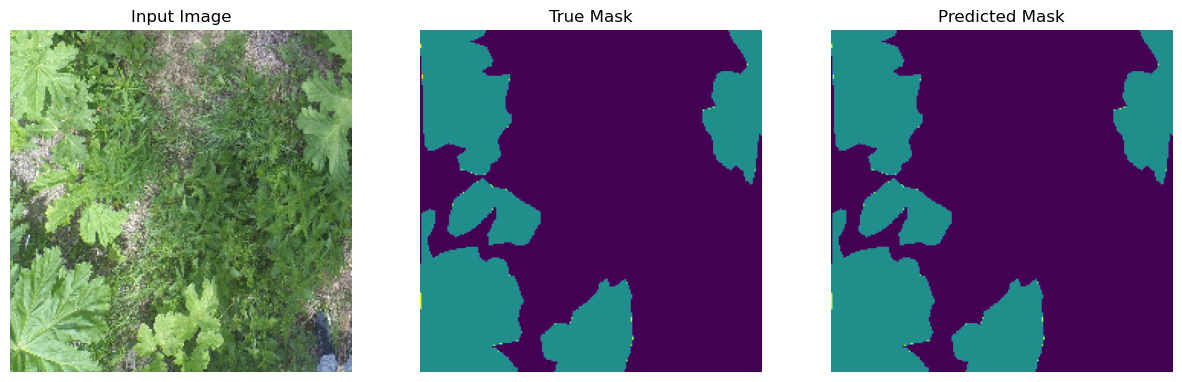

In [4]:
def load_images_and_masks(image_folder, mask_folder):
    image_filenames = os.listdir(image_folder)
    images = []
    masks = []
    for img_file in image_filenames:
        img_path = os.path.join(image_folder, img_file)
        mask_file = img_file  
        mask_path = os.path.join(mask_folder, mask_file)
        img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img)
        mask = keras.preprocessing.image.load_img(mask_path, color_mode="grayscale", target_size=(224, 224))
        mask_array = keras.preprocessing.image.img_to_array(mask)
        images.append(img_array)
        masks.append(mask_array)
    return np.array(images), np.array(masks)

image_folder = 'image_kwadranten'
mask_folder = 'mask_kwadranten'

images, masks = load_images_and_masks(image_folder, mask_folder)
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 
            'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

# Assuming you want to display the first image and its mask from the training set
sample_image, sample_mask = train_images[8], train_masks[8]
display_list = [sample_image, sample_mask, sample_mask]  # Assuming no predicted mask available yet

display_images(display_list)

In [5]:
width, height = 224, 224

base_model = keras.applications.vgg16.VGG16(
	include_top=False, input_shape=(width, height, 3))

layer_names = [
	'block1_pool',
	'block2_pool',
	'block3_pool',
	'block4_pool',
	'block5_pool',
]
base_model_outputs = [base_model.get_layer(
	name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
							base_model_outputs)

2024-03-25 17:07:53.555232: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-03-25 17:07:53.555298: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-03-25 17:07:53.555301: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-03-25 17:07:53.555355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-25 17:07:53.555377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same', 
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same', 
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu', 
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2), 
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu', 
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o

In [7]:
def segmentation_model():
	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)
	return model

opt = keras.optimizers.legacy.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])

1/1 [==============================] - 0s 172ms/step


2024-03-25 17:07:54.350072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


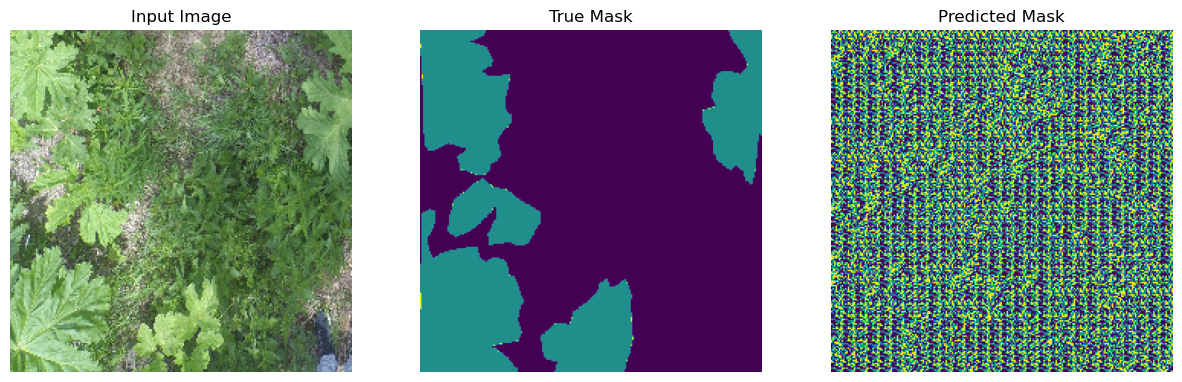

In [8]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]

def show_predictions(dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [9]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(BATCH_SIZE)

model_history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10


/Users/vince/tensorflow-test/env/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-03-25 17:07:55.888944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - ETA: 0s - loss: 12.7874 - accuracy: 0.3764

2024-03-25 17:08:13.372091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 21s 739ms/step - loss: 12.7874 - accuracy: 0.3764 - val_loss: 1.7058 - val_accuracy: 0.4406
Epoch 2/10
27/27 [==============================] - 20s 719ms/step - loss: 1.2960 - accuracy: 0.4809 - val_loss: 1.1423 - val_accuracy: 0.5151
Epoch 3/10
27/27 [==============================] - 19s 710ms/step - loss: 1.0737 - accuracy: 0.5349 - val_loss: 1.0143 - val_accuracy: 0.5600
Epoch 4/10
27/27 [==============================] - 19s 705ms/step - loss: 0.9419 - accuracy: 0.5814 - val_loss: 0.8691 - val_accuracy: 0.6217
Epoch 5/10
27/27 [==============================] - 20s 729ms/step - loss: 0.7705 - accuracy: 0.6764 - val_loss: 0.7100 - val_accuracy: 0.7107
Epoch 6/10
27/27 [==============================] - 20s 729ms/step - loss: 0.5577 - accuracy: 0.7619 - val_loss: 0.4866 - val_accuracy: 0.8119
Epoch 7/10
27/27 [==============================] - 20s 741ms/step - loss: 0.3696 - accuracy: 0.8541 - val_loss: 0.3957 - val_accuracy: 0.8776
Epoch 8/1

In [10]:
def plot_loss_and_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracies')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

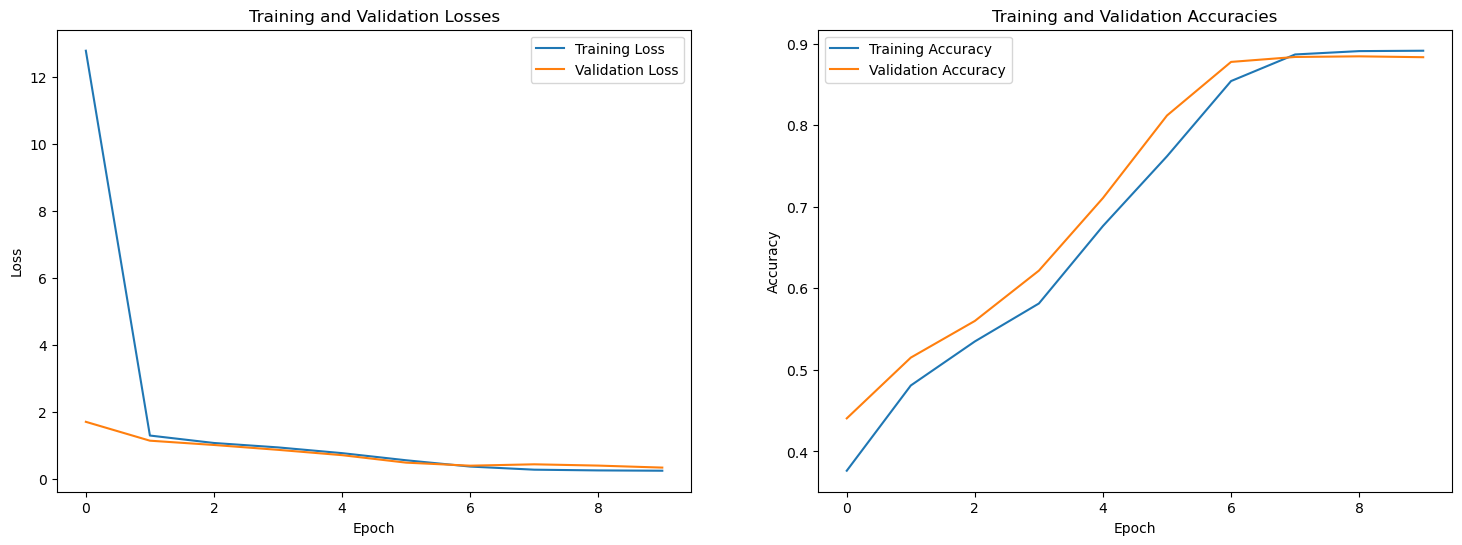

In [11]:
plot_loss_and_accuracy(model_history)

1/1 [==============================] - 0s 40ms/step


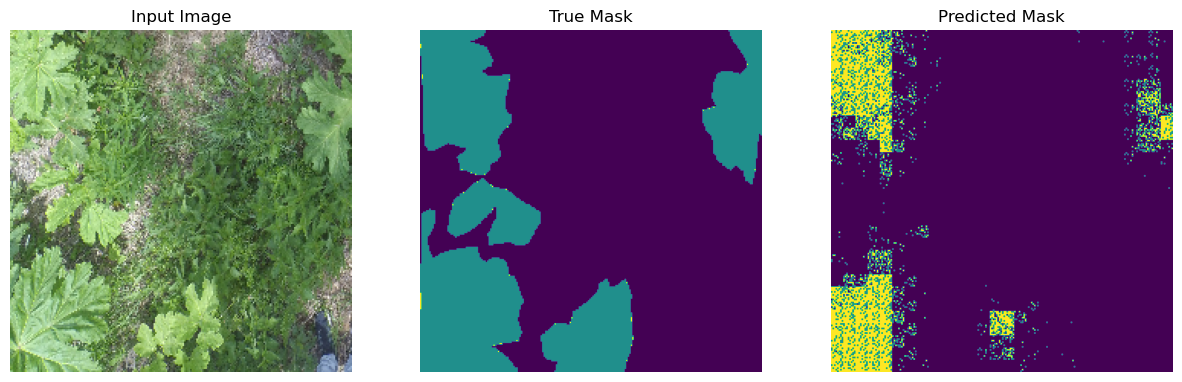

In [12]:
show_predictions()